# **Baseline Simple MLP with just MSE**
# All years data


## **Running the models using the 'modelling' package**

A notebook through which different modelling configurations can be ran, using the ``modelling`` package. It follows the steps of:
- preparing packages;
- setting "global" variables;
- getting the data;
- defining hyperparameters;
- running a grid search and/or training a model; and
- evaluation.
In the modelling package, variations can be made to the models and training functions to experiment. Don't forget to restart the notebook after making changes there.



For loading models, go to the ``src/results/models``:
- Baseline NO2 2017 with MLP and MSE loss: ``best_mlp_no2_baseline_2017.pth``


In [1]:
print("Starting script...")


from modelling.MLP import BasicMLP
from modelling import *


import optuna
import threading
import os
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

Starting script...

Running __init__.py for data pipeline...
Modelling package initialized



Use GPU when available

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cpu


### **Set "global" variables**

In [3]:
Path.cwd()

PosixPath('/home/rachel/forecasting_smog_PEML/src')

In [4]:
import importlib
import config
importlib.reload(config)

<module 'config' from '/home/rachel/forecasting_smog_PEML/src/config.py'>

In [5]:
from config import *

In [6]:
HABROK = bool(0)                  # set to True if using HABROK; it will print
                                  # all stdout to a .txt file to log progress


print("BASE_DIR: ", BASE_DIR)
print("MODEL_PATH: ", MODEL_PATH)
print("Results path: ", RESULTS_PATH)

torch.manual_seed(34)             # set seed for reproducibility


BASE_DIR:  /home/rachel/forecasting_smog_PEML
MODEL_PATH:  /home/rachel/forecasting_smog_PEML/src/results/models
Results path:  /home/rachel/forecasting_smog_PEML/src/results



## MODIFY THESE GLOBAL VARIABLES FOR YOUR MODEL SCENARIO
## all other variables are defined in config.py

In [7]:
# Change this according to the data you want to use
YEARS = [2017, 2018, 2020, 2021, 2022, 2023]
TRAIN_YEARS = [2017, 2018, 2020, 2021, 2022]
VAL_YEARS = [2021, 2022, 2023]
TEST_YEARS = [2021, 2022, 2023]

# for loss.py and also naming of file names
LOSS_FUNC = "MSE" # choose from "MSE"; "Physics_Linear_MSE"; "Physics_PDE_numerical_constant"; "Physics_PDE_numerical_piecewise"
NN_TYPE = "MLP" # choose from "MLP", "RNN", "LSTM", "GRU"
torch.random.manual_seed(34)

In [8]:
if YEARS == [2017, 2018, 2020, 2021, 2022, 2023]:
    years = "allyears"
    MINMAX_PATH = MINMAX_PATH_ALLYEARS
    DATASET_PATH = DATASET_PATH_ALLYEARS
    
    print("Using all years")
    
elif YEARS == [2017]:
    years = "2017"
    MINMAX_PATH = MINMAX_PATH_2017
    DATASET_PATH = DATASET_PATH_2017
    print("Using 2017")
else:
    raise ValueError("Invalid years selected")


MODEL_PATH_NAME = f'best_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.pth'
RESULTS_METRICS_FILENAME = f'results_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.csv'
BESTPARAMS_FILENAME = f'best_params_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.txt'
PLOT_FILENAME = f'plot_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.png'
print("MINMAX_PATH: ", MINMAX_PATH)
print("DATASET_PATH: ", DATASET_PATH)
print("MODEL_PATH_NAME: ", MODEL_PATH_NAME)
print("RESULTS_METRICS_FILENAME: ", RESULTS_METRICS_FILENAME)
print("BESTPARAMS_FILENAME: ", BESTPARAMS_FILENAME)
print("PLOT_FILENAME: ", PLOT_FILENAME)

Using all years
MINMAX_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/all_years/pollutants_minmax_allyears.csv
DATASET_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/all_years
MODEL_PATH_NAME:  best_MLP_no2_MSE_allyears.pth
RESULTS_METRICS_FILENAME:  results_MLP_no2_MSE_allyears.csv
BESTPARAMS_FILENAME:  best_params_MLP_no2_MSE_allyears.txt
PLOT_FILENAME:  plot_MLP_no2_MSE_allyears.png


### **Load in data and create PyTorch *Datasets***

In [9]:
# Load in data and create PyTorch Datasets. To tune
# which exact .csv files get extracted, change the
# lists in the get_dataframes() definition

train_input_frames = get_dataframes('train', 'u', YEARS, DATASET_PATH)
train_output_frames = get_dataframes('train', 'y', YEARS, DATASET_PATH)

val_input_frames = get_dataframes('val', 'u', YEARS, DATASET_PATH)
val_output_frames = get_dataframes('val', 'y', YEARS, DATASET_PATH)

test_input_frames = get_dataframes('test', 'u', YEARS, DATASET_PATH)
test_output_frames = get_dataframes('test', 'y', YEARS, DATASET_PATH)

print("Successfully loaded data")

Imported train_2017_combined_u.csv


Imported train_2018_combined_u.csv
Imported train_2020_combined_u.csv
Imported train_2021_combined_u.csv
Imported train_2022_combined_u.csv
Imported train_2017_combined_y.csv
Imported train_2018_combined_y.csv
Imported train_2020_combined_y.csv
Imported train_2021_combined_y.csv
Imported train_2022_combined_y.csv
Imported val_2021_combined_u.csv
Imported val_2022_combined_u.csv
Imported val_2023_combined_u.csv
Imported val_2021_combined_y.csv
Imported val_2022_combined_y.csv
Imported val_2023_combined_y.csv
Imported test_2021_combined_u.csv
Imported test_2022_combined_u.csv
Imported test_2023_combined_u.csv
Imported test_2021_combined_y.csv
Imported test_2022_combined_y.csv
Imported test_2023_combined_y.csv
Successfully loaded data


In [10]:
train_input_frames

[                           DD        FF        FH        FX  NO2_BREUKELEN  \
 DateTime                                                                     
 2017-08-01 00:00:00  0.166667  0.083333  0.083333  0.043478       0.207556   
 2017-08-01 01:00:00  0.000000  0.000000  0.083333  0.086957       0.140351   
 2017-08-01 02:00:00  0.000000  0.000000  0.000000  0.043478       0.252483   
 2017-08-01 03:00:00  0.277778  0.083333  0.000000  0.043478       0.379467   
 2017-08-01 04:00:00  0.805556  0.166667  0.083333  0.130435       0.426715   
 ...                       ...       ...       ...       ...            ...   
 2017-12-30 19:00:00  0.694444  0.416667  0.416667  0.478261       0.201615   
 2017-12-30 20:00:00  0.694444  0.416667  0.333333  0.434783       0.217859   
 2017-12-30 21:00:00  0.666667  0.333333  0.416667  0.434783       0.221480   
 2017-12-30 22:00:00  0.694444  0.250000  0.250000  0.304348       0.209505   
 2017-12-30 23:00:00  0.666667  0.416667  0.250000  

In [11]:
train_dataset = TimeSeriesDataset(
    train_input_frames,  # list of input training dataframes
    train_output_frames, # list of output training dataframes
    len(TRAIN_YEARS),                   # number of dataframes put in for both
                         # (basically len(train_input_frames) and
                         # len(train_output_frames) must be equal)
    N_HOURS_U,           # number of hours of input data
    N_HOURS_Y,           # number of hours of output data
    N_HOURS_STEP,        # number of hours between each input/output pair
)
val_dataset = TimeSeriesDataset(
    val_input_frames,    # etc.
    val_output_frames,
    len(VAL_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)
test_dataset = TimeSeriesDataset(
    test_input_frames,
    test_output_frames,
    len(TEST_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)

del train_input_frames, train_output_frames
del val_input_frames, val_output_frames
del test_input_frames, test_output_frames

In [12]:
train_dataset.u

[                           DD        FF        FH        FX  NO2_BREUKELEN  \
 DateTime                                                                     
 2017-08-01 00:00:00  0.166667  0.083333  0.083333  0.043478       0.207556   
 2017-08-01 01:00:00  0.000000  0.000000  0.083333  0.086957       0.140351   
 2017-08-01 02:00:00  0.000000  0.000000  0.000000  0.043478       0.252483   
 2017-08-01 03:00:00  0.277778  0.083333  0.000000  0.043478       0.379467   
 2017-08-01 04:00:00  0.805556  0.166667  0.083333  0.130435       0.426715   
 ...                       ...       ...       ...       ...            ...   
 2017-12-30 19:00:00  0.694444  0.416667  0.416667  0.478261       0.201615   
 2017-12-30 20:00:00  0.694444  0.416667  0.333333  0.434783       0.217859   
 2017-12-30 21:00:00  0.666667  0.333333  0.416667  0.434783       0.221480   
 2017-12-30 22:00:00  0.694444  0.250000  0.250000  0.304348       0.209505   
 2017-12-30 23:00:00  0.666667  0.416667  0.250000  

In [13]:
train_dataset.y

[                          NO2
 DateTime                     
 2017-08-01 00:00:00  0.207556
 2017-08-01 01:00:00  0.140351
 2017-08-01 02:00:00  0.252483
 2017-08-01 03:00:00  0.379467
 2017-08-01 04:00:00  0.426715
 ...                       ...
 2017-12-30 19:00:00  0.201615
 2017-12-30 20:00:00  0.217859
 2017-12-30 21:00:00  0.221480
 2017-12-30 22:00:00  0.209505
 2017-12-30 23:00:00  0.240787
 
 [3648 rows x 1 columns],
                           NO2
 DateTime                     
 2018-08-01 00:00:00  0.572728
 2018-08-01 01:00:00  0.490485
 2018-08-01 02:00:00  0.511928
 2018-08-01 03:00:00  0.430428
 2018-08-01 04:00:00  0.387450
 ...                       ...
 2018-12-30 19:00:00  0.273554
 2018-12-30 20:00:00  0.245336
 2018-12-30 21:00:00  0.189548
 2018-12-30 22:00:00  0.169312
 2018-12-30 23:00:00  0.124478
 
 [3648 rows x 1 columns],
                           NO2
 DateTime                     
 2020-08-01 00:00:00  0.115845
 2020-08-01 01:00:00  0.173953
 2020-08-01 02

In [14]:
len(train_dataset.pairs[0][0])

72

In [15]:
train_dataset.pairs[0][0]

tensor([[0.1667, 0.0833, 0.0833, 0.0435, 0.2076, 0.2234, 0.6349, 0.0000, 0.4974,
         0.7230],
        [0.0000, 0.0000, 0.0833, 0.0870, 0.1404, 0.2071, 0.6392, 0.0000, 0.5053,
         0.7338],
        [0.0000, 0.0000, 0.0000, 0.0435, 0.2525, 0.1579, 0.6335, 0.0000, 0.4735,
         0.6942],
        [0.2778, 0.0833, 0.0000, 0.0435, 0.3795, 0.1377, 0.6307, 0.0000, 0.4392,
         0.6511],
        [0.8056, 0.1667, 0.0833, 0.1304, 0.4267, 0.1496, 0.6307, 0.0000, 0.4630,
         0.6727],
        [0.0000, 0.0000, 0.0833, 0.1304, 0.4310, 0.2847, 0.6378, 0.3000, 0.5635,
         0.7482],
        [0.7222, 0.0833, 0.0833, 0.0870, 0.3823, 0.4730, 0.6506, 0.0000, 0.5820,
         0.7230],
        [0.7500, 0.0833, 0.0833, 0.1304, 0.3783, 0.4766, 0.6520, 0.0000, 0.5873,
         0.7050],
        [0.7222, 0.1667, 0.1667, 0.1304, 0.3354, 0.4598, 0.6534, 0.0000, 0.6058,
         0.6691],
        [0.7500, 0.1667, 0.1667, 0.2174, 0.3959, 0.3985, 0.6548, 0.3000, 0.6376,
         0.6367],
        [0

In [16]:
train_dataset.pairs[0][1]

tensor([[0.1842],
        [0.1443],
        [0.1457],
        [0.2406],
        [0.4900],
        [0.4313],
        [0.3199],
        [0.2520],
        [0.1827],
        [0.1643],
        [0.1446],
        [0.1315],
        [0.0821],
        [0.1171],
        [0.1264],
        [0.1217],
        [0.1050],
        [0.1010],
        [0.0851],
        [0.0860],
        [0.1145],
        [0.0873],
        [0.0643],
        [0.1017]])

In [17]:
# Assuming train_dataset.u[0] is a pandas Index object with column names
column_names = list(train_dataset.u[0])  # Convert Index to list


print("No2 tuindorp idx: ", column_names.index('NO2_TUINDORP'))
print("No2 breukelen idx: ", column_names.index('NO2_BREUKELEN'))
print("wind dir (dd) idx: ", column_names.index('DD'))
print("wind speed (fh) idx: ", column_names.index('FH'))

# check if the indices are the same as whats defined in config.py
assert column_names.index('NO2_TUINDORP')== NO2_TUINDORP_IDX
assert column_names.index('NO2_BREUKELEN') == NO2_BREUKELEN_IDX
assert column_names.index('DD') == WIND_DIR_IDX
assert column_names.index('FH') == WIND_SPEED_IDX
print("Column indices are same as config.py")



No2 tuindorp idx:  5
No2 breukelen idx:  4
wind dir (dd) idx:  0
wind speed (fh) idx:  2
Column indices are same as config.py


In [18]:
train_dataset.u[0].iloc[:,NO2_TUINDORP_IDX]

DateTime
2017-08-01 00:00:00    0.223383
2017-08-01 01:00:00    0.207092
2017-08-01 02:00:00    0.157895
2017-08-01 03:00:00    0.137659
2017-08-01 04:00:00    0.149633
                         ...   
2017-12-30 19:00:00    0.168848
2017-12-30 20:00:00    0.140072
2017-12-30 21:00:00    0.191033
2017-12-30 22:00:00    0.147406
2017-12-30 23:00:00    0.158823
Name: NO2_TUINDORP, Length: 3648, dtype: float64

In [19]:
train_dataset.u[0].iloc[:,NO2_BREUKELEN_IDX]

DateTime
2017-08-01 00:00:00    0.207556
2017-08-01 01:00:00    0.140351
2017-08-01 02:00:00    0.252483
2017-08-01 03:00:00    0.379467
2017-08-01 04:00:00    0.426715
                         ...   
2017-12-30 19:00:00    0.201615
2017-12-30 20:00:00    0.217859
2017-12-30 21:00:00    0.221480
2017-12-30 22:00:00    0.209505
2017-12-30 23:00:00    0.240787
Name: NO2_BREUKELEN, Length: 3648, dtype: float64

In [20]:
train_dataset.u[0].iloc[:,WIND_DIR_IDX]

DateTime
2017-08-01 00:00:00    0.166667
2017-08-01 01:00:00    0.000000
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.277778
2017-08-01 04:00:00    0.805556
                         ...   
2017-12-30 19:00:00    0.694444
2017-12-30 20:00:00    0.694444
2017-12-30 21:00:00    0.666667
2017-12-30 22:00:00    0.694444
2017-12-30 23:00:00    0.666667
Name: DD, Length: 3648, dtype: float64

In [21]:
train_dataset.u[0].iloc[:,WIND_SPEED_IDX]

DateTime
2017-08-01 00:00:00    0.083333
2017-08-01 01:00:00    0.083333
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.000000
2017-08-01 04:00:00    0.083333
                         ...   
2017-12-30 19:00:00    0.416667
2017-12-30 20:00:00    0.333333
2017-12-30 21:00:00    0.416667
2017-12-30 22:00:00    0.250000
2017-12-30 23:00:00    0.250000
Name: FH, Length: 3648, dtype: float64

## Simple MSE Loss function

In [ ]:
def objective(trial):
    # Define hyperparameters to search over
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 1, 5)
    n_hidden_units = trial.suggest_int("n_hidden_units", 32, 256)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])  # Match the original hp['batch_sz']

    # Create train & validation loaders (following the original code)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize MLP model
    model = BasicMLP(
        N_INPUT_UNITS=train_dataset.__n_features_in__(),
        N_HIDDEN_LAYERS=n_hidden_layers,
        N_HIDDEN_UNITS=n_hidden_units,
        N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
        loss_function=LOSS_FUNC,
    )

    # Train and return validation loss
    val_loss, _ = model.train_model(train_loader, val_loader, epochs=50, lr=lr, weight_decay=weight_decay, device=device)
    
    return val_loss


# Run Optuna optimization
study = optuna.create_study(direction="minimize", study_name="mlp_hyperparameter_optimization_baseline_allyears", storage="sqlite:///mlp_hyperparameter_optimization.db", load_if_exists=True)

study.optimize(objective, n_trials=100)

# Print best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

In [23]:
# Interrupted tuning since it was taking too long (at 50 trials)
# Copied best params directly from the .db file on optuna dashboard
best_params = {'n_hidden_layers': 4, 'n_hidden_units': 191, 'lr': 0.0002099693529342787, 'weight_decay': 3.4334611075297167e-07, 'batch_size': 8}

In [24]:
print(f"Best Hyperparameters for {NN_TYPE} {LOSS_FUNC} {years}:", best_params)

Best Hyperparameters for MLP MSE allyears: {'n_hidden_layers': 4, 'n_hidden_units': 191, 'lr': 0.0002099693529342787, 'weight_decay': 3.4334611075297167e-07, 'batch_size': 8}


### Save the params to a file

In [ ]:

import json

file_path = f"{RESULTS_PATH}/best_params/{BESTPARAMS_FILENAME}"

with open(file_path, "w") as f:
    json.dump(best_params, f, indent=4)  # Pretty format for readability

print(f"Best Hyperparameters saved to {file_path}")




### Read params from file

In [ ]:

with open(file_path, "r") as f:
    best_params = json.load(f)  # Automatically converts it to a dictionary

print("Loaded Best Parameters:", best_params)

In [25]:
# save best params to a file
with open(f'{RESULTS_PATH}/best_params/{BESTPARAMS_FILENAME}', 'w') as f:
    for key in best_params.keys():
        f.write("%s: %s\n" % (key, best_params[key]))
print(f"Best Hyperparameters saved to file {RESULTS_PATH}/best_params/{BESTPARAMS_FILENAME}")

Best Hyperparameters saved to file /home/rachel/forecasting_smog_PEML/src/results/best_params/best_params_MLP_no2_MSE_allyears.txt


In [27]:
torch.manual_seed(34)
# Train the model with the best hyperparameters
best_model_baseline = BasicMLP(
    N_INPUT_UNITS=train_dataset.__n_features_in__(),
    N_HIDDEN_LAYERS=best_params["n_hidden_layers"],
    N_HIDDEN_UNITS=best_params["n_hidden_units"],
    N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
    loss_function="MSE",
)

# Create train & validation loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Train the model
_, training_time = best_model_baseline.train_model(train_loader, val_loader, epochs=50, lr=best_params["lr"], weight_decay=best_params["weight_decay"], device=device)

print(f"Training time: {training_time}")
# Save the trained model
torch.save(best_model_baseline.state_dict(), f"{MODEL_PATH}/{MODEL_PATH_NAME}")
print(f"Model saved as {MODEL_PATH_NAME} in Model folder")

Epoch 1/50
Epoch 1/50 - Train Loss: 0.025931 - Val Loss (simple RMSE, no physics involved): 0.091189
Epoch 2/50
Epoch 2/50 - Train Loss: 0.008366 - Val Loss (simple RMSE, no physics involved): 0.068853
Epoch 3/50
Epoch 3/50 - Train Loss: 0.007393 - Val Loss (simple RMSE, no physics involved): 0.069202
Epoch 4/50
Epoch 4/50 - Train Loss: 0.007283 - Val Loss (simple RMSE, no physics involved): 0.073100
Epoch 5/50
Epoch 5/50 - Train Loss: 0.007205 - Val Loss (simple RMSE, no physics involved): 0.072101
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007277 - Val Loss (simple RMSE, no physics involved): 0.069022
Epoch 7/50
Epoch 7/50 - Train Loss: 0.007064 - Val Loss (simple RMSE, no physics involved): 0.067482
Epoch 8/50
Epoch 8/50 - Train Loss: 0.006969 - Val Loss (simple RMSE, no physics involved): 0.075144
Epoch 9/50
Epoch 9/50 - Train Loss: 0.007103 - Val Loss (simple RMSE, no physics involved): 0.074466
Epoch 10/50
Epoch 10/50 - Train Loss: 0.007041 - Val Loss (simple RMSE, no physics involved

In [28]:
torch.manual_seed(34)  # Set seed for reproducibility
best_model_baseline.load_state_dict(torch.load(f"{MODEL_PATH}/{MODEL_PATH_NAME}"))
best_model_baseline.eval()

# Create the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Evaluate the model on the test dataset
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
min_value = df_minmax["min"].values
max_value = df_minmax["max"].values
mse, rmse, smape, inference_time = best_model_baseline.test_model(test_loader, min_value=min_value, max_value=max_value, device="cpu")



Test MSE Loss: 59.653010
Test RMSE Loss: 6.568753
Test SMAPE Loss: 26.350127%
Total Inference Time: 0.39 seconds


In [29]:
import csv

# Define the CSV file path
results_csv_path = f"{RESULTS_PATH}/metrics/{RESULTS_METRICS_FILENAME}"

# Save metrics in a proper CSV format (header + values in one row)
with open(results_csv_path, mode="w", newline="") as f:
    writer = csv.writer(f)
    
    # Write header
    writer.writerow(["MSE", "RMSE", "SMAPE", "Inference Time", "Training Time"])
    
    # Write values
    writer.writerow([mse, rmse, smape, inference_time, training_time])

print(f"Results saved as {RESULTS_METRICS_FILENAME} in Results/metrics folder")

Results saved as results_MLP_no2_MSE_allyears.csv in Results/metrics folder


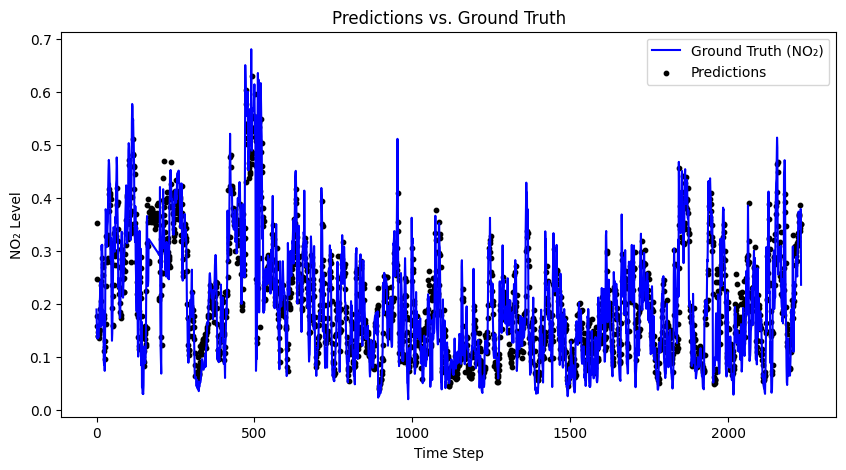

In [30]:
import torch
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
best_model_baseline.eval()

y_preds = []
y_trues = []

# Iterate through the test set and collect predictions & ground truth
with torch.no_grad():
    for batch in test_loader:
        x_test, y_true = batch  # Get input and ground truth
        x_test = x_test.to("cpu")  # Ensure data is on CPU if needed

        # Get predictions
        y_pred = best_model_baseline(x_test)

        # Store results
        y_preds.append(y_pred.cpu())
        y_trues.append(y_true.cpu())

# Convert lists to tensors
y_preds = torch.cat(y_preds, dim=0).numpy()
y_trues = torch.cat(y_trues, dim=0).numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_trues.flatten(), label="Ground Truth (NO₂)", linestyle="-", color="blue")
plt.scatter(range(len(y_preds.flatten())), y_preds.flatten(), label="Predictions", color="black", s=10)

plt.xlabel("Time Step")
plt.ylabel("NO₂ Level")
plt.title("Predictions vs. Ground Truth")
plt.legend()
#save the plot
plt.savefig(f"{RESULTS_PATH}/plots/{PLOT_FILENAME}")
plt.show()
